In [1]:
import os
import numpy as np
import pandas as pd

Note For this to work, you will need the `lsst.sims` stack to be installed. 
 - opsimsummary uses `healpy` which is installed with the sims stack, but also available from conda

In [2]:
import opsimsummary as oss
from opsimsummary import Tiling, HealpixTiles
# import snsims
import healpy as hp

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

## This section pertains to how to write a new Tiling class

```
noTile = snsims.Tiling()
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-9-5f6f8a94508e> in <module>()
----> 1 noTile = snsims.Tiling()

TypeError: Can't instantiate abstract class Tiling with abstract methods __init__, area, pointingSequenceForTile, tileIDSequence, tileIDsForSN
```

The class `snsims.Tiling` is an abstract Base class. Therefore, this cannot be instantiated. It must be subclassed, and the set of methods outlined have to be implemented for this to work.

In [5]:
class NoTile(Tiling):
    pass

In [6]:
noTile = NoTile()

TypeError: Can't instantiate abstract class NoTile with abstract methods __init__, area, pointingSequenceForTile, positions, tileIDSequence, tileIDsForSN


```
"""noTile = NoTile()
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-4-8ddedac7fb97> in <module>()
----> 1 noTile = NoTile()

TypeError: Can't instantiate abstract class NoTile with abstract methods __init__, area, pointingSequenceForTile, positions, tileIDSequence, tileIDsForSN
"""
```

The above fails because the methods are not implemented. Below is a stupid (ie. not useful) but minimalist class that would work:

In [7]:
class MyTile(Tiling):
    def __init__(self):
        pass
    @property
    def tileIDSequence(self):
        return np.arange(100)
    
    def tileIDsForSN(self, ra, dec):
        x = ra + dec
        y = np.remainder(x, 100.)
        return np.floor(y)
    def area(self, tileID):
        return 1.
    def pointingSequenceForTile(self, tileID, pointings):
        return None
    def positions(self):
        pass
    

In [8]:
myTile = MyTile()

## Using the class HealpixTiles

Currently there is only concrete tiling class that has been implemented. This is the `snsims.HealpixTiles` class.

This shows how to use the HealpixTiles Class

In [9]:
issubclass(HealpixTiles, Tiling)

True

In [10]:
help(HealpixTiles)

Help on class HealpixTiles in module opsimsummary.healpixTiles:

class HealpixTiles(opsimsummary.tessellations.Tiling)
 |  A concrete Tiling class based on Healpix Tiles. The user is
 |  allowed to choose the following parameters:
 |  
 |  Attributes
 |  ----------
 |  nside : int, power of 2, defaults to 256
 |      healpix nside parameter
 |  
 |  Method resolution order:
 |      HealpixTiles
 |      opsimsummary.tessellations.Tiling
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nside=256, healpixelizedOpSim=None, preComputedMap=None)
 |      nside : int, power of 2, defaults to 256
 |          nside parameter of healpix. determines the size of the tiles
 |          so that there are 12 * nside **2 equally sized tiles covering
 |          the sphere.
 |  
 |  area(self, tileID)
 |  
 |  pointingSequenceForTile(self, tileID, allPointings=None, columns=None, **kwargs)
 |      return a maximal sequence of pointings for a particular tileID.
 |  
 |  po

In [11]:
datadir = os.path.join(oss.__path__[0], 'example_data')
opsimdb = os.path.join(datadir, 'enigma_1189_micro.db')
healpixelizedDB = os.path.join(datadir, 'healpixels_micro.db')
#opsimdb = '/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db'

In [12]:
NSIDE = 256

In [13]:
hpOpSim = oss.HealPixelizedOpSim.fromOpSimDB(opsimdb, NSIDE=NSIDE)

 reading from database sqlite:////Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/example_data/enigma_1189_micro.db
SELECT * FROM Summary WHERE PROPID in (366, 364)


In [14]:
opsout = oss.OpSimOutput.fromOpSimDB(opsimdb)

 reading from database sqlite:////Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/example_data/enigma_1189_micro.db
SELECT * FROM Summary WHERE PROPID in (366, 364)


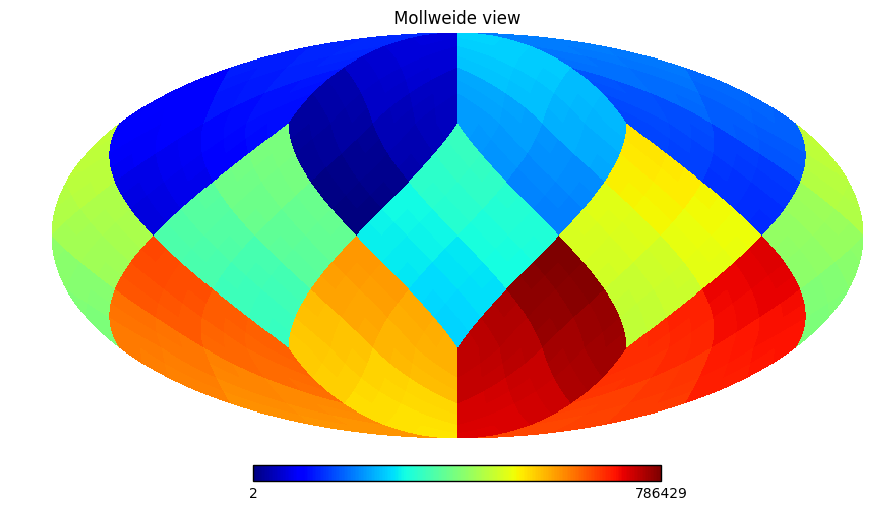

In [15]:
#x = np.ones(hp.nside2npix(256)) * hp.UNSEEN
#x[1] = -1
x = np.arange(hp.nside2npix(256))
hp.mollview(x, nest=True)

In [15]:
hptiles = HealpixTiles(healpixelizedOpSim=hpOpSim, nside=NSIDE)

In [16]:
from opsimsummary import HPTileVis

In [17]:
hptvis = HPTileVis(hptiles, opsout)

In [18]:
from opsimsummary import pixelsForAng, plot_south_steradian_view

In [19]:
pixelsForAng(54., -27.5, 4)

array([141])

In [20]:
ra, dec = hptvis.pointingCenters(0)

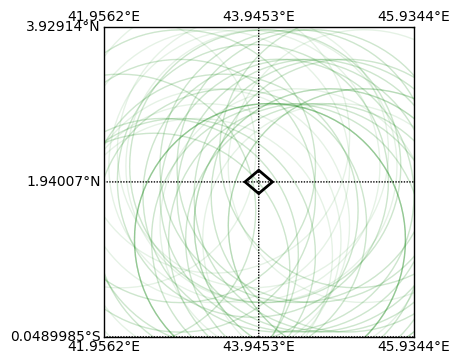

In [22]:
figoverlaps = hptvis.plotTilePointings(135, projection='cyl', paddingFactors=1,
                                       query='night < 365',
                                       **dict(fill=False, color='g', alpha=0.1))

### Faster evaluations with preComputedMap

In [23]:
hpchips = HealpixTiles(nside=128, preComputedMap=healpixelizedDB)

In [24]:
hpvis = HPTileVis(hpchips, opsout)

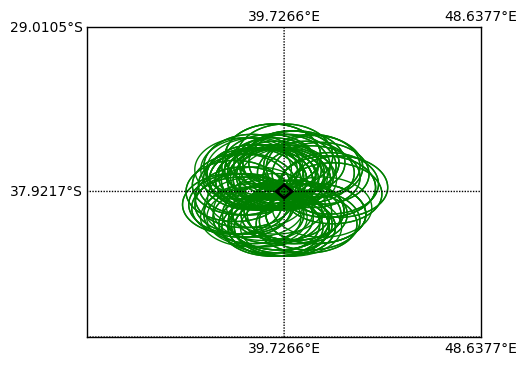

In [25]:
fig2, tc, _ = hpvis.plotTilePointings(140785, projection='cea', paddingFactors=4,
                               drawPointings=True,
                               **dict(fill=False, color='g', alpha=1.0))

# Scratch

In [47]:
figtile.savefig('HealpixTile_Pointings.pdf')

In [276]:
from opsimsummary import convertToCelestialCoordinates, healpix_boundaries, pixelsForAng
from matplotlib.patches import Polygon

In [371]:
class HPTileVis(HealpixTiles):
    def __init__(self, hpTile, opsout):
        """
        """
        self.hpTile = hpTile
        self.opsout = opsout
        self.nside = self.hpTile.nside
    
    def tileIDfromCelestialCoordinates(self, ra, dec, opsout, units='degrees'):
        """
        Parameters
        -----------
        ra : 
        dec : 
        units: {'degrees', 'radians'}
        """
        return pixelsForAng(lon=ra,lat=dec, unit=units )
    def tileCenter(self, tileID):
        theta, phi = hp.pix2ang(self.nside, tileID, nest=True)
        ra, dec = convertToCelestialCoordinates(theta, phi, input_unit='radians',
                                                output_unit='degrees')
        return ra, dec
        
    def pointingSummary(self, tileID, columns=('ditheredRA', 'ditheredDec'), 
                        allPointings=None):
        #if allPointings is None:
        #    allPointings = opsout.summary
        #    if query is not None:
        #        allPointings = allPointings.query(query)
        #    allPointings = allPointings.index.values
        obsHistIDs = self.hpTile.pointingSequenceForTile(tileID=tileID,
                                                         allPointings=allPointings)
        return self.opsout.summary.ix[obsHistIDs]#[list(columns)]
    def pointingCenters(self,
                tileID,
                raCol='ditheredRA',
                decCol='ditheredDec',
                query=None):
        summary = self.pointingSummary(tileID)#, columns=[raCol, decCol])
        
        if query is not None:
            summary = summary.query(query)
        ra = summary[raCol].apply(np.degrees).values
        dec = summary[decCol].apply(np.degrees).values
        return ra, dec
    def plotTilePointings(self, tileID, raCol='ditheredRA', decCol='ditheredDec', radius=1.75,
                          paddingFactors=1, query=None, ax=None, projection='cyl',**kwargs):
        """
        Parameters
        ----------
        
        """
        if ax is None:
            fig, ax = plt.subplots()
        padding = np.degrees(hp.max_pixrad(self.nside)) + radius
        ra_tile, dec_tile = self.tileCenter(tileID)
        
        llcrnrlat = dec_tile - padding * paddingFactors
        urcrnrlat = dec_tile + padding * paddingFactors
        llcrnrlon = ra_tile - padding * paddingFactors
        urcrnrlon = ra_tile + padding * paddingFactors
        
        m = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon,
                    urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
                    projection=projection, lon_0=ra_tile, lat_0=dec_tile,
                    ax=ax)
        
        parallels = np.linspace(llcrnrlat, urcrnrlat, 3)
        meridians = np.linspace(llcrnrlon, urcrnrlon, 3)
        m.drawparallels(parallels, labels=(1, 0, 0, 0)) #np.ones(len(parallels), dtype=bool))
        m.drawmeridians(meridians, labels=(0, 1, 1, 1)) #np.ones(len(meridians), dtype=bool))
        ra, dec = self.pointingCenters(tileID, raCol=raCol, decCol=decCol, query=query)
        lon, lat = healpix_boundaries(tileID, nside=self.nside, units='degrees',
                                      convention='celestial', step=10,
                                      nest=True)
        x, y = m(lon, lat)
        xy = zip(x, y)
        healpixels = Polygon(xy, facecolor='w',fill=False, alpha=1., edgecolor='k', lw=2)
        for ra, dec in zip(ra, dec):
            m.tissot(ra, dec, radius, 100, **kwargs)
        ax.add_patch(healpixels)
        return fig

In [365]:
tileID = pixelsForAng(54., -27.5, 4, unit='degrees')

In [366]:
tileID

array([141])

In [367]:
theta, phi = hp.pix2ang(hptiles.nside, 0, nest=True)
ra, dec = oss.convertToCelestialCoordinates(theta, phi)

(array([ 45.]), array([ 9.59406823]))

In [372]:
hptvis = HPTileVis(hptiles, opsout)

In [388]:
from palettable.colorbrewer import sequential

In [389]:
import palettable

In [ ]:
palettable

In [ ]:
from matplotlib.colorbar import 

(<matplotlib.figure.Figure at 0x10ddf5450>,
 (202.49999999999997, -30.000000000000014),
 (-46.322230670077914,
  186.17776932992206,
  -13.677769329922114,
  218.82223067007789))

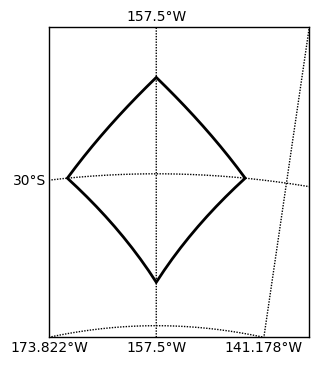

In [81]:
hptvis.plotTilePointings(, raCol='ditheredRA', decCol='ditheredDec', projection='gnom',
                         query=None,#'night <3650',
                         **dict(fill=False, color='g', alpha=1., lw=1., ls='solid'))

In [376]:
hptvis.centers(0)

AttributeError: 'HPTileVis' object has no attribute 'centers'

In [115]:
opsout.summary.ix[hpTileshpOpSim.pointingSequenceForTile(0, allPointings=None)][['ditheredRA', 'ditheredDec']]

,ditheredRA,ditheredDec
obsHistID,,
179157,0.694620,0.013076
179167,0.694620,0.013076
179965,0.698441,0.013076
179998,0.698441,0.013076
180029,0.698441,0.013076
180068,0.698441,0.013076
181880,0.669784,0.016382
182972,0.728329,0.014223
183105,0.673605,0.016382


In [16]:
phi, theta = hpTileshpOpSim.positions(1, 10000)

In [17]:
mapvals = np.ones(hp.nside2npix(NSIDE)) * hp.UNSEEN

In [18]:
mapvals[1] = 100

In [19]:
hp.ang2pix(NSIDE, np.radians(theta), np.radians(phi), nest=True)

array([13, 13, 13, ..., 13, 15, 15])

In [20]:
theta_c, phi_c = hp.pix2ang(4, 1, nest=True)

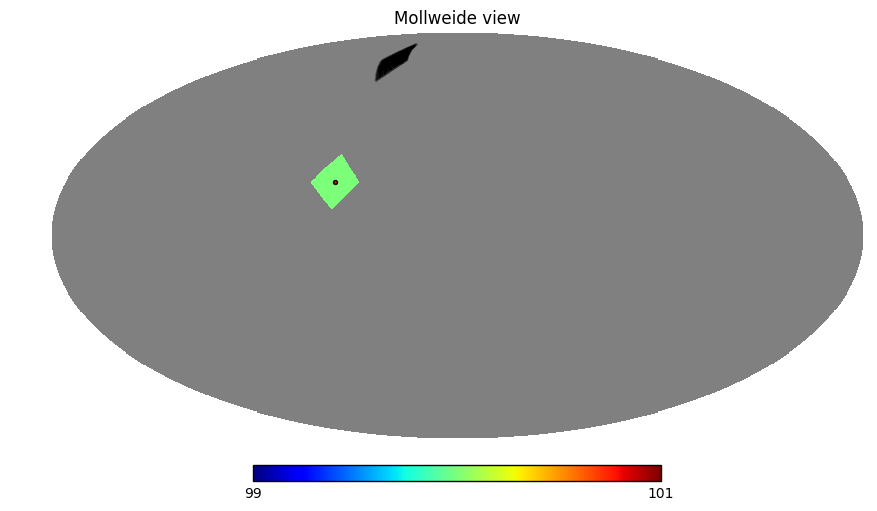

In [21]:
hp.mollview(mapvals, nest=True)
hp.projscatter(np.radians(theta), np.radians(phi), **dict(s=0.0002))
hp.projscatter(theta_c, phi_c, **dict(s=8., c='r'))

In [22]:
%timeit hpTileshpOpSim.pointingSequenceForTile(33, allPointings=None)

100 loops, best of 3: 2.29 ms per loop


In [23]:
preCompMap = os.path.join(oss.__path__[0], 'example_data', 'healpixels_micro.db')

In [26]:
import os
os.path.exists(preCompMap)

True

In [24]:
hpTilesMap = HealpixTiles(nside=1, preComputedMap=preCompMap)

In [25]:
obsHistIDs = hpTilesMap.pointingSequenceForTile(10, allPointings=None)

OperationalError: (sqlite3.OperationalError) no such table: simlib [SQL: 'SELECT obsHistID FROM simlib WHERE ipix == 10']

In [28]:
from sqlalchemy import create_engine

In [36]:
engine = create_engine('sqlite:////' + preCompMap)

In [37]:
import pandas as pd

In [38]:
df = pd.read_sql_query('SELECT * FROM simlib Limit 5', engine)

OperationalError: (sqlite3.OperationalError) no such table: simlib [SQL: 'SELECT * FROM simlib Limit 5']

In [35]:
preCompMap

'/Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/example_data/healpixels_micro.db'

In [35]:
%timeit hpOpSim.obsHistIdsForTile(34)

100 loops, best of 3: 2.49 ms per loop


In [36]:
hpTiles = HealpixTiles(healpixelizedOpSim=hpOpSim)

In [37]:
hpTiles.pointingSequenceForTile(34, allPointings=None)

array([], dtype=int64)

In [390]:
df = opsout.summary.copy()

In [393]:
df.fieldID.unique().size

2264

In [398]:
df.query('fieldID == 744')[['fieldRA', 'fieldDec', 'ditheredRA', 'ditheredDec', 'expMJD', 'filter']].head()

,fieldRA,fieldDec,ditheredRA,ditheredDec,expMJD,filter
obsHistID,,,,,,
175159,0.0,-0.794553,6.277736,-0.821004,49573.415395,u
175744,0.0,-0.794553,0.000000,-0.821004,49574.225892,u
175746,0.0,-0.794553,0.000000,-0.821004,49574.226725,u
175748,0.0,-0.794553,0.000000,-0.821004,49574.227570,u
175750,0.0,-0.794553,0.000000,-0.821004,49574.228403,u


In [399]:
df.query('fieldID == 744')['ditheredDec'] = df.query('fieldID == 744')['fieldDec']

/usr/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [405]:
def fixdec(mydf, fieldIDs):
    return mydf.fieldID.apply(lambda x: x in fieldIDs)

In [407]:
fixdec(df, (744, 1427, 290)).astype(np.int) * df.fieldRA + (1.0 - fixdec(df, (744, 1427, 290)).astype(np.int))

obsHistID
171077    0
171078    0
171079    0
171080    0
171081    0
171082    0
171083    0
171084    0
171085    0
171086    0
171087    0
171088    0
171089    0
171090    0
171091    0
171092    0
171093    0
171094    0
171095    0
171096    0
171097    0
171098    0
171099    0
171100    0
171101    0
171102    0
171103    0
171104    0
171105    0
171106    0
         ..
272045    1
272046    1
272047    1
272048    1
272049    1
272050    1
272051    1
272052    1
272053    1
272054    1
272405    0
272406    0
272407    0
272408    0
272409    0
272410    0
272411    0
272412    0
272413    0
272414    0
272415    0
272416    0
272417    0
272418    0
272419    0
272420    0
272421    0
272422    0
272423    0
272424    0
Name: fieldID, dtype: int64

In [400]:
df.query('fieldID == 744')[['fieldRA', 'fieldDec', 'ditheredRA', 'ditheredDec', 'expMJD', 'filter']].head()

,fieldRA,fieldDec,ditheredRA,ditheredDec,expMJD,filter
obsHistID,,,,,,
175159,0.0,-0.794553,6.277736,-0.821004,49573.415395,u
175744,0.0,-0.794553,0.000000,-0.821004,49574.225892,u
175746,0.0,-0.794553,0.000000,-0.821004,49574.226725,u
175748,0.0,-0.794553,0.000000,-0.821004,49574.227570,u
175750,0.0,-0.794553,0.000000,-0.821004,49574.228403,u


In [54]:
df = opsout.summary.copy()

In [55]:
grouped = df.groupby('propID')

In [59]:
grouped.groups.keys()

[364, 366]

In [62]:
grouped.get_group(366).fieldRA

obsHistID
231872    0.925184
231873    0.925184
231874    0.925184
231875    0.925184
231876    0.925184
231877    0.925184
231878    0.925184
231879    0.925184
231880    0.925184
231881    0.925184
231882    0.925184
231883    0.925184
231884    0.925184
231885    0.925184
231886    0.925184
231887    0.925184
231888    0.925184
231889    0.925184
231890    0.925184
231892    0.925184
231893    0.925184
231894    0.925184
231895    0.925184
231896    0.925184
231897    0.925184
231898    0.925184
231899    0.925184
231900    0.925184
231902    0.925184
231903    0.925184
            ...   
272045    0.925184
272046    0.925184
272047    0.925184
272048    0.925184
272049    0.925184
272050    0.925184
272051    0.925184
272052    0.925184
272053    0.925184
272054    0.925184
272405    2.624318
272406    2.624318
272407    2.624318
272408    2.624318
272409    2.624318
272410    2.624318
272411    2.624318
272412    2.624318
272413    2.624318
272414    2.624318
272415    2.624318
27